<a href="https://colab.research.google.com/github/ridvanyigit/Tensorflow-2.0/blob/main/Google_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Stock Price Prediction Using RNN - LSTM

Dataset: https://finance.yahoo.com/quote/GOOG/history/

#### Import Libraries (Time Series)

In [158]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM

#### Defining Parameters

In [159]:
# Stock ticker symbol
ticker = "GOOG"

# Start and end dates for data retrieval
start_date = "2004-01-01"
end_date = "2024-03-27"

#### Downloading Data

In [160]:
# Download historical data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2004-08-19,2.487352,2.579567,2.378775,2.478923,897427216
2004-08-20,2.684922,2.704009,2.491318,2.503960,458857488
2004-08-23,2.711942,2.813082,2.703266,2.745408,366857939
2004-08-24,2.599647,2.766478,2.567421,2.757554,306396159
2004-08-25,2.627659,2.677238,2.575105,2.601878,184645512


#### Cleaning Column Names

In [161]:
data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]
data.head()

,Close,High,Low,Open,Volume
Date,,,,,
2004-08-19,2.487352,2.579567,2.378775,2.478923,897427216
2004-08-20,2.684922,2.704009,2.491318,2.503960,458857488
2004-08-23,2.711942,2.813082,2.703266,2.745408,366857939
2004-08-24,2.599647,2.766478,2.567421,2.757554,306396159
2004-08-25,2.627659,2.677238,2.575105,2.601878,184645512


#### Creating 'Date' Column and Resetting Index

In [162]:
# Creating 'Date' column from index
data['Date'] = data.index

# Resetting index to default integer index and dropping the old index
data = data.reset_index(drop=True)
data.head()

,Close,High,Low,Open,Volume,Date
0,2.487352,2.579567,2.378775,2.478923,897427216,2004-08-19
1,2.684922,2.704009,2.491318,2.503960,458857488,2004-08-20
2,2.711942,2.813082,2.703266,2.745408,366857939,2004-08-23
3,2.599647,2.766478,2.567421,2.757554,306396159,2004-08-24
4,2.627659,2.677238,2.575105,2.601878,184645512,2004-08-25


#### Reordering Columns

In [163]:
column_order = ['Date'] + [col for col in data.columns if col != 'Date']
data = data[column_order]
data.head()

,Date,Close,High,Low,Open,Volume
0,2004-08-19,2.487352,2.579567,2.378775,2.478923,897427216
1,2004-08-20,2.684922,2.704009,2.491318,2.503960,458857488
2,2004-08-23,2.711942,2.813082,2.703266,2.745408,366857939
3,2004-08-24,2.599647,2.766478,2.567421,2.757554,306396159
4,2004-08-25,2.627659,2.677238,2.575105,2.601878,184645512


In [164]:
type(data)

pandas.core.frame.DataFrame

In [165]:
data.tail()

,Date,Close,High,Low,Open,Volume
4929,2024-03-20,148.974380,149.054005,146.968880,148.088577,17730000
4930,2024-03-21,148.038818,150.591714,147.312249,149.611372,19843900
4931,2024-03-22,151.054535,151.840804,149.382447,149.531749,19226300
4932,2024-03-25,150.437454,150.742011,148.098542,150.238400,15114700
4933,2024-03-26,150.984848,152.477777,150.318008,150.527025,19312700


In [166]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4934 entries, 0 to 4933
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4934 non-null   datetime64[ns]
 1   Close   4934 non-null   float64       
 2   High    4934 non-null   float64       
 3   Low     4934 non-null   float64       
 4   Open    4934 non-null   float64       
 5   Volume  4934 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 231.4 KB


#### Split Data

In [167]:
data_training = data[data['Date'] < '2019-01-01'].copy()
data_test = data[data['Date'] >= '2019-01-01'].copy()

In [168]:
data_training.tail()

,Date,Close,High,Low,Open,Volume
3612,2018-12-24,48.580898,49.940456,48.276838,48.465444,31806000
3613,2018-12-26,51.727993,51.754866,48.918303,49.217385,47466000
3614,2018-12-27,51.947956,51.948453,49.615004,50.617754,42196000
3615,2018-12-28,51.609550,52.529194,51.411487,52.233594,28296000
3616,2018-12-31,51.536400,52.386871,50.938235,52.300284,29866000


In [169]:
training_data = data_training.drop(['Date'], axis=1)

In [170]:
training_data.head()

,Close,High,Low,Open,Volume
0,2.487352,2.579567,2.378775,2.478923,897427216
1,2.684922,2.704009,2.491318,2.503960,458857488
2,2.711942,2.813082,2.703266,2.745408,366857939
3,2.599647,2.766478,2.567421,2.757554,306396159
4,2.627659,2.677238,2.575105,2.601878,184645512


#### Scale Training Data

In [171]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data[0:5]

array([[1.34923996e-04, 9.44776806e-04, 0.00000000e+00, 3.30290594e-04,
        5.43577158e-01],
       [3.39309315e-03, 2.98910187e-03, 1.88268662e-03, 7.42147380e-04,
        2.77885883e-01],
       [3.83868912e-03, 4.78093321e-03, 5.42828586e-03, 4.71387379e-03,
        2.22151354e-01],
       [1.98680263e-03, 4.01532221e-03, 3.15577594e-03, 4.91367825e-03,
        1.85522817e-01],
       [2.44875100e-03, 2.54929967e-03, 3.28433357e-03, 2.35285736e-03,
        1.11764684e-01]])

In [173]:
training_data.shape[0]

3617

#### Prepare Training Sequences

In [174]:
X_train = []
y_train = []

for i in range(60, training_data.shape[0]):
    X_train.append(training_data[i-60:i])
    y_train.append(training_data[i, 0])

Convert to NumPy Arrays

In [175]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [176]:
X_train.shape, y_train.shape

((3557, 60, 5), (3557,))

## Build LSTM

#### Build LSTM Model

In [178]:
regressor = Sequential()

regressor.add(Input(shape=(X_train.shape[1], 5)))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=60, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=80, return_sequences=True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units=120))
regressor.add(Dropout(0.5))

regressor.add(Dense(units=1))

#### Model Summary

In [179]:
regressor.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 60, 50)              │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 60, 60)              │          26,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 60, 60)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 60, 80)              │          45,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 60, 80)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 120)                 │          96,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 179,561 (701.41 KB)

 Trainable params: 179,561 (701.41 KB)

 Non-trainable params: 0 (0.00 B)

#### Compile LSTM Model

In [180]:
regressor.compile(
    optimizer='adam',
    loss='mean_squared_error'
    )

#### Train LSTM Model

In [182]:
regressor.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64
    )

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 228ms/step - loss: 0.0033
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 259ms/step - loss: 0.0032
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 237ms/step - loss: 0.0038
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - loss: 0.0028
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - loss: 0.0029
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - loss: 0.0024
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - loss: 0.0020
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - loss: 0.0021
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - loss: 0.0023
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - loss: 0.0020
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - loss: 0.0018
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - loss: 0.0022
Epoch 13/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - loss: 0.0018
Epoch 14/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - loss: 0.0016
Epoch 15/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 

#### Prepare Test Dataset

In [183]:
data_test.head()

,Date,Close,High,Low,Open,Volume
3617,2019-01-02,52.045986,52.367963,50.546090,50.588887,30652000
3618,2019-01-03,50.563511,52.599863,50.464477,51.804630,36822000
3619,2019-01-04,53.283127,53.289596,51.128731,51.386114,41878000
3620,2019-01-07,53.167671,53.446851,52.489384,53.322440,39638000
3621,2019-01-08,53.560314,53.972364,52.776528,53.551855,35298000


In [184]:
data_training.tail(60)

,Date,Close,High,Low,Open,Volume
3557,2018-10-04,58.134151,59.593240,57.506425,59.484753,44190000
3558,2018-10-05,57.594704,58.398396,56.986087,58.099811,23686000
3559,2018-10-08,57.177681,58.124695,56.102470,57.234411,38648000
3560,2018-10-09,56.672577,57.445413,56.610470,57.037346,26174000
3561,2018-10-10,53.806152,56.341644,53.801672,56.287400,53514000
3562,2018-10-11,53.711594,55.059211,53.161700,53.394097,58980000
3563,2018-10-12,55.242344,55.487183,54.064022,55.138834,42026000
3564,2018-10-15,54.355049,55.409852,54.193317,55.184122,27448000
3565,2018-10-16,55.799706,55.946012,54.865133,54.969140,38570000
3566,2018-10-17,55.521526,56.183392,54.849709,56.057490,29344000


#### Get Last 60 Days (Training)

In [185]:
past_60_days = data_training.tail(60)

#### Concatenate Data

In [186]:
df = pd.concat([past_60_days, data_test], ignore_index=True)
df

,Date,Close,High,Low,Open,Volume
0,2018-10-04,58.134151,59.593240,57.506425,59.484753,44190000
1,2018-10-05,57.594704,58.398396,56.986087,58.099811,23686000
2,2018-10-08,57.177681,58.124695,56.102470,57.234411,38648000
3,2018-10-09,56.672577,57.445413,56.610470,57.037346,26174000
4,2018-10-10,53.806152,56.341644,53.801672,56.287400,53514000
...,...,...,...,...,...,...
1372,2024-03-20,148.974380,149.054005,146.968880,148.088577,17730000
1373,2024-03-21,148.038818,150.591714,147.312249,149.611372,19843900
1374,2024-03-22,151.054535,151.840804,149.382447,149.531749,19226300
1375,2024-03-25,150.437454,150.742011,148.098542,150.238400,15114700


In [187]:
df = df.drop(['Date'], axis=1)
df.head()

,Close,High,Low,Open,Volume
0,58.134151,59.593240,57.506425,59.484753,44190000
1,57.594704,58.398396,56.986087,58.099811,23686000
2,57.177681,58.124695,56.102470,57.234411,38648000
3,56.672577,57.445413,56.610470,57.037346,26174000
4,53.806152,56.341644,53.801672,56.287400,53514000


#### Transform Input Data

In [188]:
inputs = scaler.transform(df)
inputs

array([[0.91781781, 0.93755777, 0.92220907, 0.93805618, 0.0266749 ],
       [0.90892166, 0.91792903, 0.91350453, 0.91527437, 0.01425331],
       [0.90204446, 0.91343271, 0.89872285, 0.90103885, 0.02331748],
       ...,
       [2.45018708, 2.4529884 , 2.45916739, 2.41929764, 0.01155156],
       [2.44001067, 2.43493759, 2.43768943, 2.4309218 , 0.0090607 ],
       [2.44903786, 2.4634525 , 2.47481803, 2.43566958, 0.0116039 ]])

#### Prepare Test Sequences

In [189]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

In [190]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((1317, 60, 5), (1317,))

Make Predictions

In [191]:
y_pred = regressor.predict(X_test)

42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step


View Scaler Scale

In [192]:
scaler.scale_

array([1.64912069e-02, 1.64278662e-02, 1.67286120e-02, 1.64496488e-02,
       6.05813073e-10])

In [193]:
scale = 1/1.64912069e-02
scale

60.63837571524253

Inverse Transform Predictions

In [194]:
y_pred = y_pred * scale
y_test = y_test * scale

## Visualization

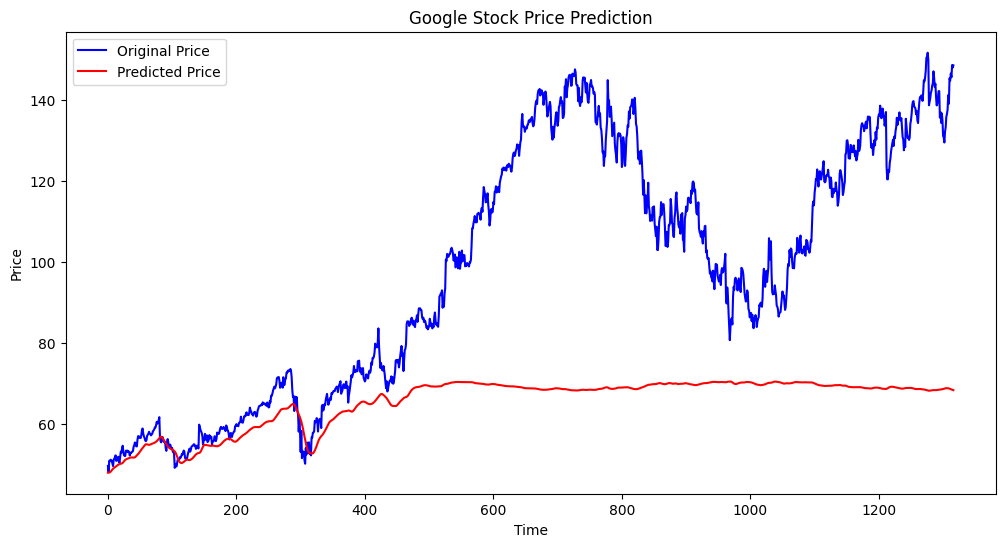

In [195]:
plt.figure(figsize=(12,6))
plt.plot(y_test, 'b', label='Original Price')
plt.plot(y_pred, 'r', label='Predicted Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()